In [22]:
from __future__ import division

import os
import numpy as np
import random
from scipy import pi
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
import imageio
import skimage.transform as sk
import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
k.clear_session()
import tensorflow as tf
import scipy.misc
import cv2
from subprocess import call
import math
import model

# Hyperparameter Changes
1. 70-30%
2. Adam- 1e-3
3. dropout=0.5
4. Final Layer: Linear 

In [23]:
DATA_FOLDER = './driving_dataset/' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


split =0.7
X = []
y = []
LIMIT=None
with open(TRAIN_FILE) as fp:
    
    for line in islice(fp,LIMIT):
        
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*0.7)

train_y = y[:split_index]
test_y = y[split_index:]          

Completed processing data.txt


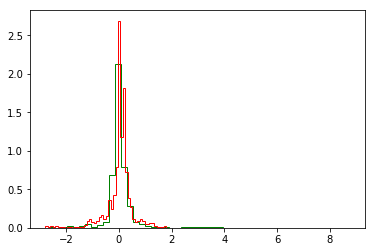

In [24]:
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()

In [25]:
train_mean_y = np.mean(train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )

Test_MSE(MEAN):0.241561
Test_MSE(ZERO):0.241107


In [26]:
import scipy.misc
import random

In [27]:
xs=[]
ys=[]

train_batch_pointer=0
val_batch_pointer=0

with open('driving_dataset/data.txt') as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        ys.append(float(line.split()[1])*scipy.pi / 180)
num_images=len(xs)
train_xs=xs[:int(len(xs)*0.7)]
train_ys=ys[:int(len(xs)*0.7)]

val_xs=xs[-int(len(xs)*0.3):]
val_ys=ys[-int(len(ys)*0.3):]

num_train_images=len(train_xs)
num_val_images=len(val_xs)

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out=[]
    y_out=[]
    for i in range(0,batch_size):
        x_out.append(sk.resize(imageio.imread(train_xs[(train_batch_pointer +i)%num_train_images])[-150:],[66,200])/255.0)
        y_out.append([train_ys[(train_batch_pointer +i)%num_train_images]])
    train_batch_pointer +=batch_size
    return x_out,y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(sk.resize(imageio.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out    

In [28]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(dtype=tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(dtype=tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob=0.5)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob=0.5)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob=0.5)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.matmul(h_fc3_drop, W_fc4) + b_fc4

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob=0.5)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.keras.activations.linear(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output

In [29]:
from tensorflow.core.protobuf import saver_pb2

In [ ]:
LOGDIR = './My_save_4'
sees=tf.InteractiveSession()
L2NormConst = 0.001
train_vars=tf.trainable_variables()
loss = tf.reduce_mean(tf.square(tf.subtract(y_,y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step=tf.train.AdamOptimizer(0.0001).minimize(loss)
sees.run(tf.global_variables_initializer())

tf.summary.scalar('loss',loss)
merged_summary_op=tf.summary.merge_all()

saver=tf.train.Saver(write_version=tf.train.SaverDef.V2)

logs_path = './my_logs_4'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100
for epoch in range(epochs):
    for i in range(int(num_images/batch_size)):
        xs,ys=LoadTrainBatch(batch_size)
        train_step.run(feed_dict={x:xs,y_:ys,keep_prob:0.6},session=sees)
        if i % 10 == 0:
            xs,ys=LoadValBatch(batch_size)
            loss_value=loss.eval(feed_dict={x:xs,y_:ys,keep_prob:1.0},session=sees)
            print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))
            
        summary=merged_summary_op.eval(feed_dict={x:xs,y_:ys,keep_prob:1.0},session=sees)
        summary_writer.add_summary(summary, epoch * num_images/batch_size + i)
        
        if i % batch_size==0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path=os.path.join(LOGDIR,'my_model_4.ckpt')
            filename = saver.save(sees, checkpoint_path)
        #print("Model saved in file: %s" % filename)                  

Epoch: 0, Step: 0, Loss: 19.0207
Epoch: 0, Step: 10, Loss: 13.0815
Epoch: 0, Step: 20, Loss: 12.4238
Epoch: 0, Step: 30, Loss: 12.1631
Epoch: 0, Step: 40, Loss: 12.1418
Epoch: 0, Step: 50, Loss: 11.6374
Epoch: 0, Step: 60, Loss: 11.6222
Epoch: 0, Step: 70, Loss: 11.6984
Epoch: 0, Step: 80, Loss: 11.4144
Epoch: 0, Step: 90, Loss: 10.9907
Epoch: 0, Step: 100, Loss: 10.8496
Epoch: 0, Step: 110, Loss: 10.6736
Epoch: 0, Step: 120, Loss: 10.5324
Epoch: 0, Step: 130, Loss: 10.6736
Epoch: 0, Step: 140, Loss: 11.0713
Epoch: 0, Step: 150, Loss: 10.4043
Epoch: 0, Step: 160, Loss: 10.8902
Epoch: 0, Step: 170, Loss: 10.0848
Epoch: 0, Step: 180, Loss: 10.4332
Epoch: 0, Step: 190, Loss: 9.97241
Epoch: 0, Step: 200, Loss: 9.48776
Epoch: 0, Step: 210, Loss: 9.35494
Epoch: 0, Step: 220, Loss: 9.23972
Epoch: 0, Step: 230, Loss: 9.22471
Epoch: 0, Step: 240, Loss: 10.076
Epoch: 0, Step: 250, Loss: 9.08156
Epoch: 0, Step: 260, Loss: 11.0373
Epoch: 0, Step: 270, Loss: 9.29244
Epoch: 0, Step: 280, Loss: 9.731

In [ ]:
#pip3 install opencv-python
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.8)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()